In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config
from event_pipeline import Event
from obspy.imaging.spectrogram import spectrogram
from event_pipeline import Event
import torchaudio.transforms as T
import librosa
import torch
import matplotlib.dates as mdates
import datetime


def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

def import_catalog(file):
    columns_to_keep = ['id', 'depth', 'relative_depth',
        'first_hydrophone', 'second_hydrophone',
       'arrival_time', 'first_arrival', 'second_arrival', 'dt',
       'max_amp', 'cum_amp', 'arrival_datetime', 'origin_time']
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    df = df[columns_to_keep].copy()
    df.sort_values(by='arrival_datetime', inplace=True)
    # # removing the events with maximum amplitude <0.1 since they are false positives
    df = df[df.max_amp > 0.1].copy()
    df.drop_duplicates(subset=['arrival_datetime',], inplace=True)
    return df


def get_event(event_id, day_number, df, hanning=True):
    paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day_number)
    waveforms = load.import_corrected_data_for_single_day(paths=paths)
    df = df.copy()
    e = Event(id=event_id
              , starttime=df.arrival_time.loc[event_id]
              , init_first_hphone=df.first_hydrophone
              , waveforms=waveforms
              , hanning=hanning
             )
    return e

def get_times(event):
    trace = event.stream[event.first_hydrophone_id]
    times = trace.times()
    times_len = times.shape[0]
    return np.arange(0, times_len, 1)

def plot_spectrogram(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    torch_data = torch.from_numpy(trace.data)
    spectrogram = T.Spectrogram(n_fft=2**6, hop_length=1)
    spec = spectrogram(torch_data)
    ax.imshow(librosa.power_to_db(spec), origin='lower', aspect='auto', cmap='gist_rainbow')
    

def plot_50hz_highpass(event, ax):
    trace = event.stream[event.first_hydrophone_id].copy()
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    ax.plot(times, tr.data, color='violet', label='50Hz highpass'
            ,linewidth=2)

def plot_aic_pick(event, ax):
    times = get_times(event=event)
    # its 0.4 because its 2/5 because its 0.2s before and 0.3 after
    aic_time = times[int(0.4*times.shape[0])]
    ax.vlines(x=aic_time, ymin=-0.5, ymax=0.7, color='cyan'
              ,linewidth=3, label='AIC pick')

def plot_p(event, ax):
    trace = event.stream[event.first_hydrophone_id]
    times = get_times(event=event)
    tr = trace.filter(type='highpass', freq=50)
    
    # find max/min peak
    start = 180
    end = 199
    if np.max(tr.data[start:end]) > np.min(tr.data[start:end]):
        ploc_t = times[np.argmax(tr.data[start:end]) + start]
        ploc_y = np.max(tr.data[start:end])
    else:
        ploc_t = times[np.argmin(tr.data[start:end]) + start]
        ploc_y = np.min(tr.data[start:end])
    
    # ax.plot(times, tr.data, color='cyan', alpha=0.5, label='what is this?')
    print(ploc_t, ploc_y)
    print(tr.data.shape)
    ax.plot(ploc_t, ploc_y, marker='*', linestyle='', color='red', label='p-arrival pick')

def plot_aic(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    ax.plot(times, AICs, color='cyan', linewidth=2.5)

def plot_aic_diff(event, ax):
    times = get_times(event=event)
    AICs = event.aics[event.first_hydrophone_id]
    aic_diffs = np.diff(AICs)
    ax.plot(times[1:], aic_diffs, color='magenta')

def plot_event(event_id, day_number, df):
    
    e = get_event(event_id=event_id, day_number=day_number, df=df)
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 8), sharex=True)

    plot_50hz_highpass(event=e, ax=ax[0])
    
    plot_aic_pick(event=e,  ax=ax[0])

    plot_p(event=e, ax=ax[0])
    
    plot_aic(event=e, ax=ax[1])
    
    ax2 = ax[1].twinx()
    
    plot_aic_diff(event=e, ax=ax2)
    
    plot_spectrogram(event=e, ax=ax[2])
    
    ax[0].set_ylabel('Pressure (Pa)', fontsize=15)
    ax[0].legend(fontsize=15, loc='upper right')
    ax[1].set_ylabel('AIC', fontsize=15, color='magenta')
    ax2.set_ylabel('diff(AIC)', fontsize=15, color='cyan')
    ax[2].set_ylabel('Hz', fontsize=15)
    ax[2].set_yticks(np.arange(0, 32, 5))
    ax[2].set_yticklabels(np.arange(0, 32, 5) * 500 / 32)
    fig.tight_layout()

In [2]:
catalog = import_catalog(file='188precision.csv')

In [5]:
vels = []
depths = []
ptimes = []

In [9]:
# %matplotlib widget
def plot_event_for_p_pick(event_id, ptime):
    fig, ax = plt.subplots(figsize=(15, 5))
    e = get_event(event_id=event_id, day_number=188, df=catalog)
    plot_50hz_highpass(event=e, ax=ax)
    plot_aic_pick(event=e, ax=ax)
    ax.arrow(x=ptime*1e3, y=0.75, dx=0, dy=-0.6, color='red', head_width=1, head_length=0.05)
    print('relative depth:', e.relative_depth)
    print('origin time:', catalog.origin_time[event_id])
    vel = e.relative_depth/(obspy.UTCDateTime(catalog.origin_time[event_id]) - ((e.starttime - 0.2) + ptime))
    print('p velocity:', vel)
    vels.append(vel)
    depths.append(e.depth)
    ptimes.append(0.2 - ptime)

In [40]:
e = get_event(event_id=126, day_number=188, df=catalog)
print('get_event().relative_depth', e.relative_depth)
print('catalog relative depth', catalog.loc[125])

get_event().relative_depth -224.875
catalog relative depth id                                                125
depth                                           170.0
relative_depth                                    0.0
first_hydrophone                                    2
second_hydrophone                                   3
arrival_time                             18084.376719
first_arrival        2019-07-07 09:02:28.523999+00:00
second_arrival       2019-07-07 09:02:28.563999+00:00
dt                                              -0.04
max_amp                                      0.950601
cum_amp                                      3.833474
arrival_datetime     2019-07-07 09:02:28.523999+00:00
origin_time               2019-07-07T09:02:28.523999Z
Name: 125, dtype: object


relative depth: -225.75
origin time: 2019-07-07T09:02:28.523999Z
p velocity: -11287.5


/home/mnky9800n/repos/boreholeCrack/event_pipeline.py:202: RuntimeWarning: invalid value encountered in sqrt
  self.radius =  np.sqrt(vrock**2 * dt**2 - dz**2)


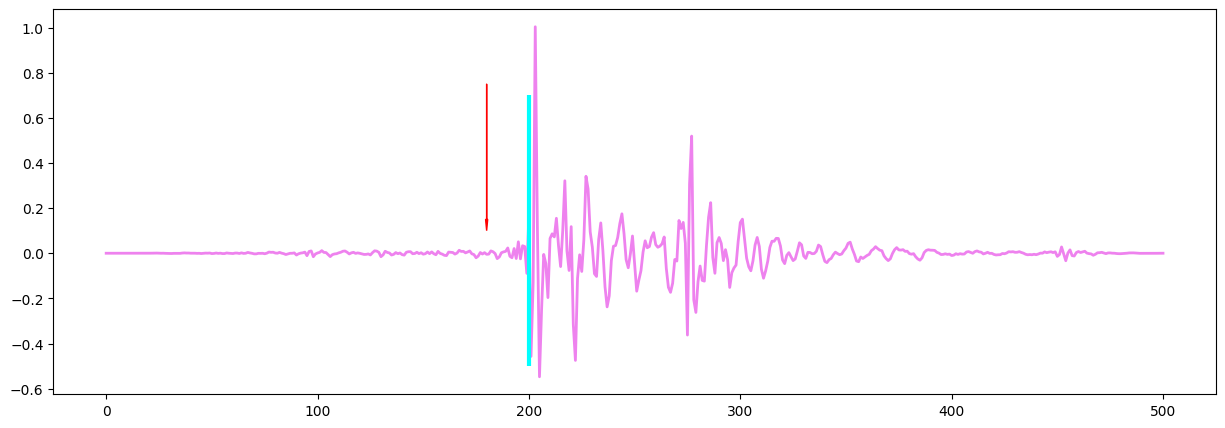

In [10]:
plot_event_for_p_pick(event_id=125, ptime=0.180)

relative depth: 7.0
origin time: 2019-07-07T09:04:28.057999Z
p velocity: 636.3636363636364


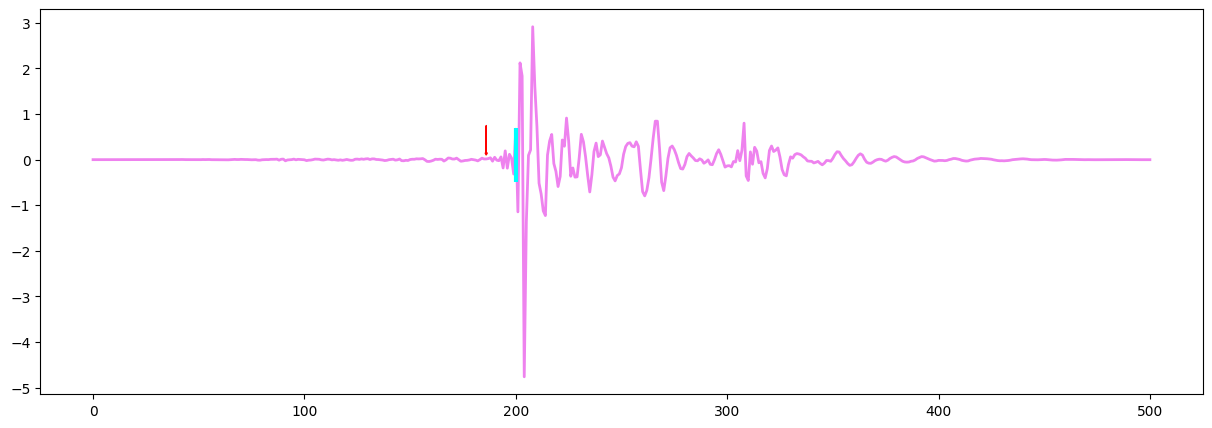

In [31]:
plot_event_for_p_pick(event_id=234, ptime=0.186)

In [35]:
catalog[catalog.id.isin(np.arange(360, 400, 1))]

,id,depth,relative_depth,first_hydrophone,second_hydrophone,arrival_time,first_arrival,second_arrival,dt,max_amp,cum_amp,arrival_datetime,origin_time
362,362,183.125,13.125,2,3,18084.379186,2019-07-07 09:06:01.659999+00:00,2019-07-07 09:06:01.684999+00:00,-0.025,1.299388,16.436933,2019-07-07 09:06:01.659999+00:00,2019-07-07T09:06:01.652499Z
363,363,181.375,11.375,2,3,18084.379192,2019-07-07 09:06:02.153999+00:00,2019-07-07 09:06:02.180999+00:00,-0.027,4.821336,31.223753,2019-07-07 09:06:02.153999+00:00,2019-07-07T09:06:02.147499Z
366,366,189.250,19.250,2,4,18084.379207,2019-07-07 09:06:03.507999+00:00,2019-07-07 09:06:03.516999+00:00,-0.009,2.676186,13.136379,2019-07-07 09:06:03.507999+00:00,2019-07-07T09:06:03.496999Z
373,373,70.250,-99.750,2,4,18084.379242,2019-07-07 09:06:06.513999+00:00,2019-07-07 09:06:06.590999+00:00,-0.077,1.215657,15.718276,2019-07-07 09:06:06.513999+00:00,2019-07-07T09:06:06.570999Z
375,375,177.000,7.000,2,3,18084.379255,2019-07-07 09:06:07.592999+00:00,2019-07-07 09:06:07.624999+00:00,-0.032,0.965352,6.577941,2019-07-07 09:06:07.592999+00:00,2019-07-07T09:06:07.588999Z
376,376,223.375,-16.625,3,4,18084.379261,2019-07-07 09:06:08.140999+00:00,2019-07-07 09:06:08.199999+00:00,-0.059,0.631586,8.044701,2019-07-07 09:06:08.141000+00:00,2019-07-07T09:06:08.150499Z
380,380,179.625,9.625,2,3,18084.379285,2019-07-07 09:06:10.240999+00:00,2019-07-07 09:06:10.269999+00:00,-0.029,1.407904,8.506339,2019-07-07 09:06:10.240999+00:00,2019-07-07T09:06:10.235499Z
393,393,184.000,14.000,2,3,18084.379360,2019-07-07 09:06:16.683999+00:00,2019-07-07 09:06:16.707999+00:00,-0.024,0.648561,8.778761,2019-07-07 09:06:16.683999+00:00,2019-07-07T09:06:16.675999Z
395,395,345.000,35.000,4,5,18084.379368,2019-07-07 09:06:17.391999+00:00,2019-07-07 09:06:17.391999+00:00,0.000,0.113887,1.246436,2019-07-07 09:06:17.391999+00:00,2019-07-07T09:06:17.371999Z


relative depth: 449.75
origin time: 2019-07-07T09:06:02.147499Z
p velocity: 99944.44444444445


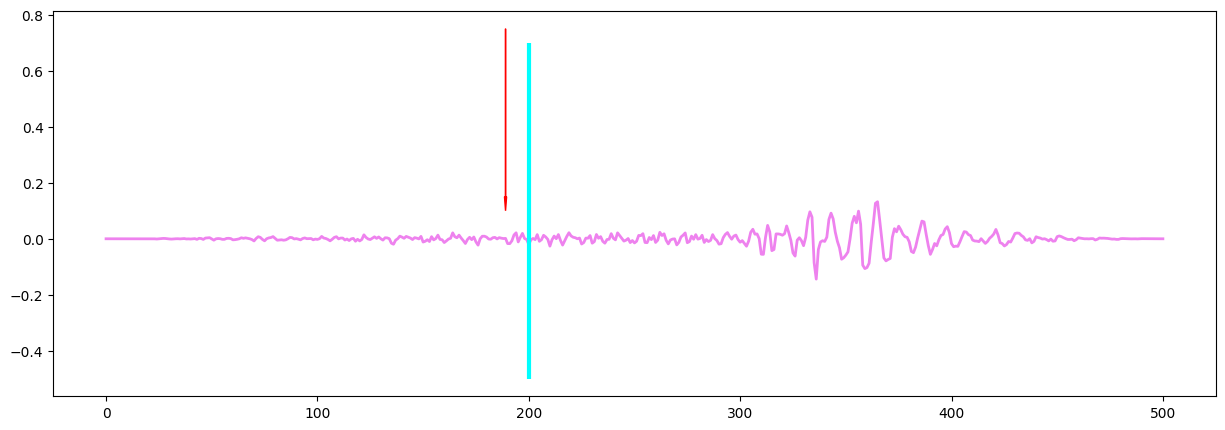

In [36]:
plot_event_for_p_pick(event_id=363, ptime=0.189)

In [ ]:
plot_event_for_p_pick(event_id=500, ptime=0.195)

In [ ]:
plot_event_for_p_pick(event_id=625, ptime=0.190)

KeyError: 750

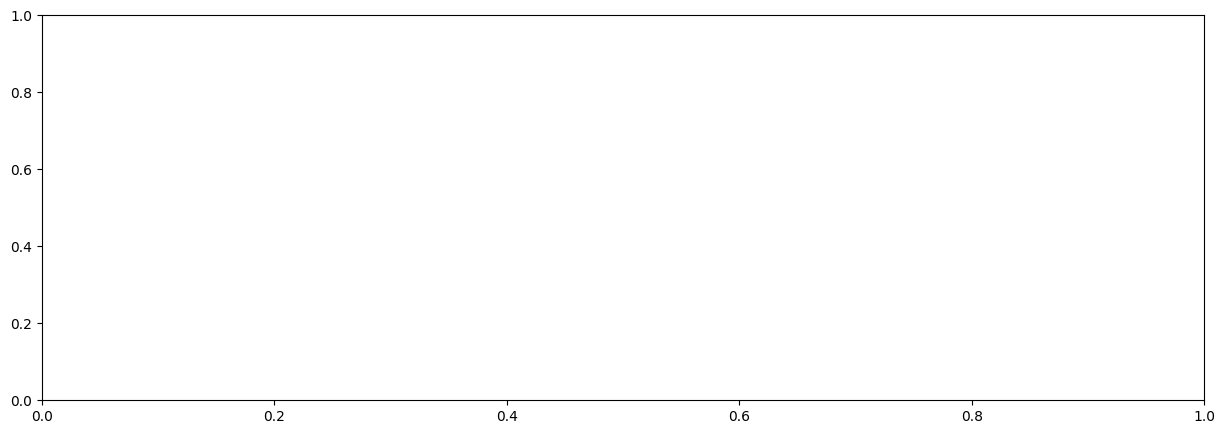

In [12]:
plot_event_for_p_pick(event_id=750, ptime=0.187)

In [ ]:
plot_event_for_p_pick(event_id=876, ptime=0.191)

In [ ]:
plot_event_for_p_pick(event_id=1002, ptime=0.187)

In [ ]:
plot_event_for_p_pick(event_id=1125, ptime=0.190)

In [ ]:
plot_event_for_p_pick(event_id=1252, ptime=0.188)

In [ ]:
plot_event_for_p_pick(event_id=1505, ptime=0.189)

In [ ]:
plot_event_for_p_pick(event_id=1676, ptime=0.192)

In [ ]:
plot_event_for_p_pick(event_id=1750, ptime=0.195)

In [ ]:
plot_event_for_p_pick(event_id=1875, ptime=0.195)

In [ ]:
plot_event_for_p_pick(event_id=2000, ptime=0.191)

In [ ]:
plot_event_for_p_pick(event_id=2128, ptime=0.191)

In [ ]:
plot_event_for_p_pick(event_id=2200, ptime=0.190)

In [ ]:
np.abs(vels).mean()

In [ ]:
np.abs(ptimes).mean()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

colors = np.linspace(0, 1, len(depths))

ax[0].scatter(depths, ptimes, c=plt.cm.Spectral(colors))
ax[0].set_xlabel('depth (meters)')
ax[0].set_ylabel('origin time - p_arrival time')

ax[1].scatter(depths, np.abs(vels), c=plt.cm.Spectral(colors))
ax[1].hlines(y=np.abs(vels).mean(), xmin=175, xmax=400, color='red')
ax[1].set_xlim(175, 400)
ax[1].set_xlabel('depth (meters)')
ax[1].set_ylabel('velocity m/s')

ax[2].scatter(ptimes, vels, c=plt.cm.Spectral(colors))
ax[2].set_xlabel('origin time - p_arrival time')
ax[2].set_ylabel('velocity m/s')

fig.tight_layout()

In [ ]:
plt.cm.Spectral